# Characterising TOI-197 with lightkurve

The star TOI-197 is the host of the first transiting planet discovered TESS for which asteroseismology was possible, as reported in [Huber et al. 2019](https://arxiv.org/abs/1901.01643). The star is a sub-giant, which means that its dipolar p-modes are starting to mix with the g-modes in the core, reducing their visibility. 

To make matters worse, we only have one sector of TESS data to observe this star with. So unlike *Kepler* data, the frequency resolution on this star will be pretty poor. Let's see what we can get out of it using lightkurve.

This notebook won't have as much commentary. Check out the example notebook on KIC 10963064 (aka Rudy) for a more in-depth introduction to the tools.

You can learn more and find tutorials at https://docs.lightkurve.org/ !

This notebook, along with others that deal with asteroseismic analysis of Kepler and TESS targets, can be found on [this GitHub repository](https://github.com/ojhall94/TASC5_lightkurve).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import lightkurve as lk

In [2]:
target = 'HIP 116158'

datalist = lk.search_lightcurvefile(target, cadence='short')
datalist

SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  441462736 tess2018234235059-s0002-0000000441462736-0121-s_lc.fits Light curves      0.0

In [3]:
lc = datalist.download().PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

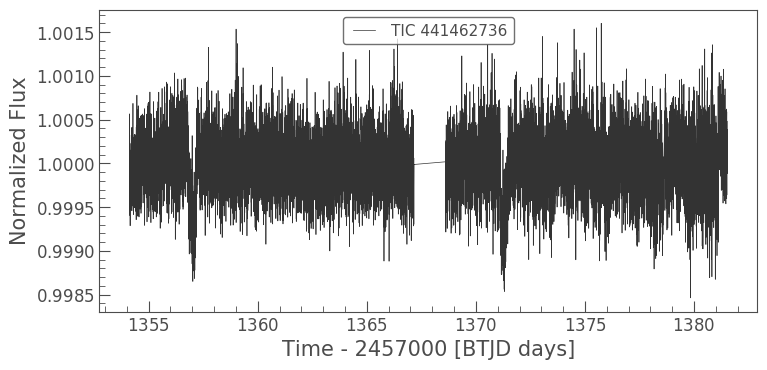

In [4]:
lc.plot()

Those transits are pretty clear! These belong to the Hot Saturn, TOI-197b, orbiting this star. We won't be using them now, but you can investigate those using lightkurve's tools as well!

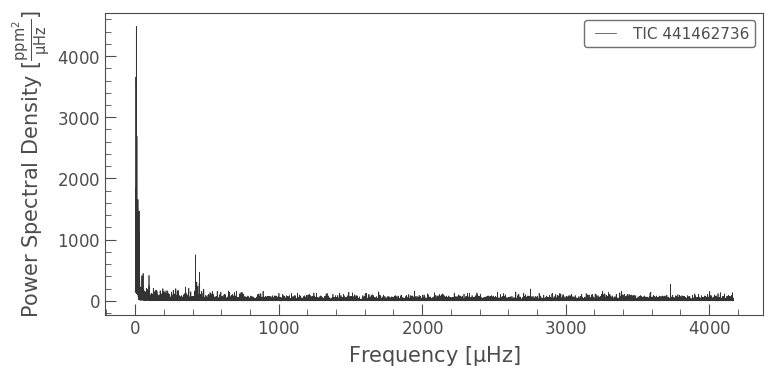

In [5]:
pg = lc.to_periodogram(normalization='psd')
pg.plot()

Looks like the interesting stuff is at low-frequency. Lets cut off all the high-frequency stuff.

In [6]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency = 100, maximum_frequency=800)

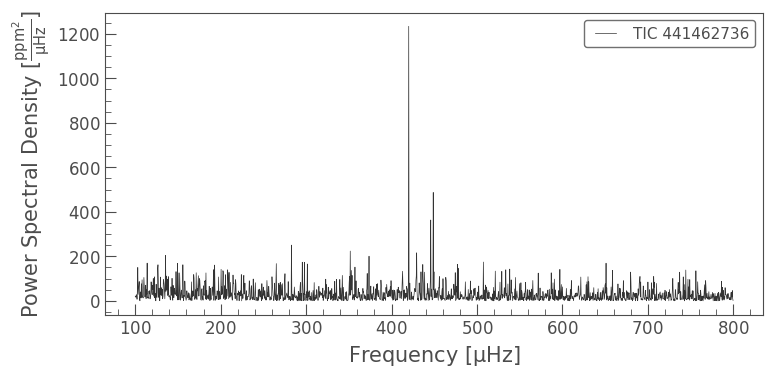

In [7]:
pg.plot()

It looks like we have a couple of very clear modes, but a lot of noise otherwise. Often its easier for methods like the ACF to see repeating structure than it is for our eyes. Hopefully this will be enough to work with. Let's find out!

Let's quickly flatten before getting onto the seismology side of things.

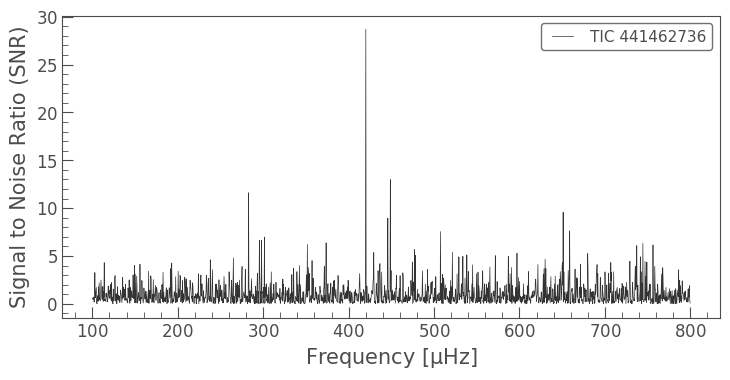

In [8]:
snr = pg.flatten()
snr.plot()

Lets throw our seismology tools at this noisier spectrum and see how they do!

In [9]:
seis = snr.to_seismology()

Since we're in the very low frequency domain, lets go ahead and reduce the window width and the spacing so that we sample smaller areas at a higher resolution as the ACF moves across the spectrum.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x126ba12b0>,
      dtype=object)

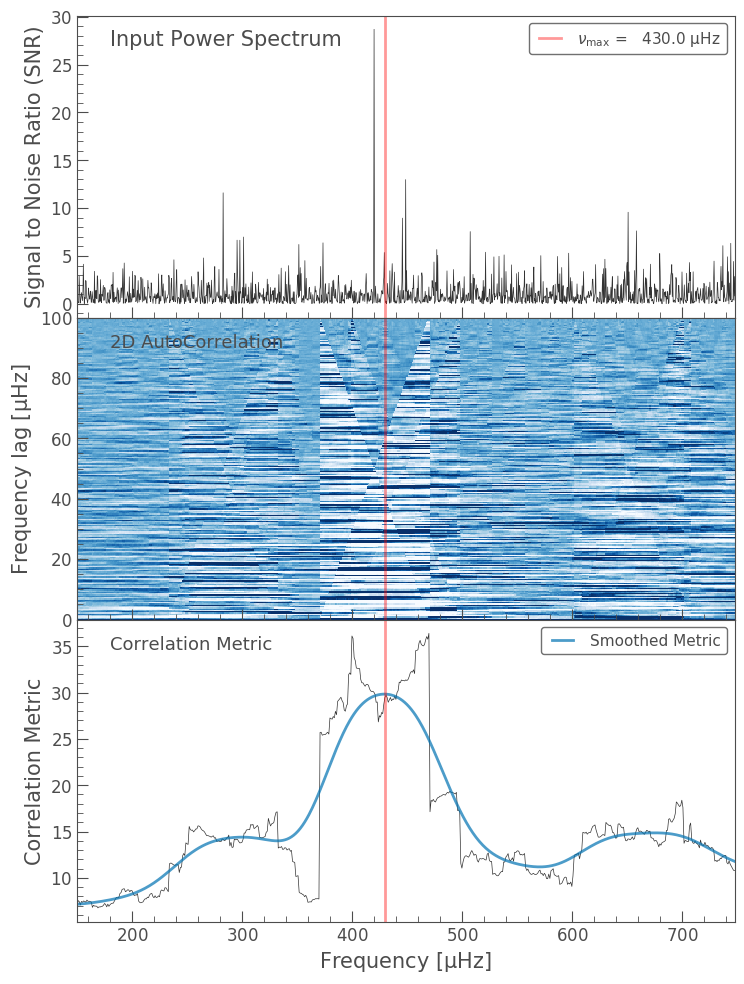

In [10]:
seis.estimate_numax(window_width=100, spacing=1)
seis.diagnose_numax()

Its messy because in this realisation of the power spectrum theres not many modes sticking out above the noice. There does appear to be an increase towards the proposed $\nu_{\rm max}$ though, even if it is a bit choppy.

Lets run with this for now and see if it returns a $\Delta\nu$ that looks decent. If it does, that will be a good indicator that our $\nu_{\rm max}$ is decent too.

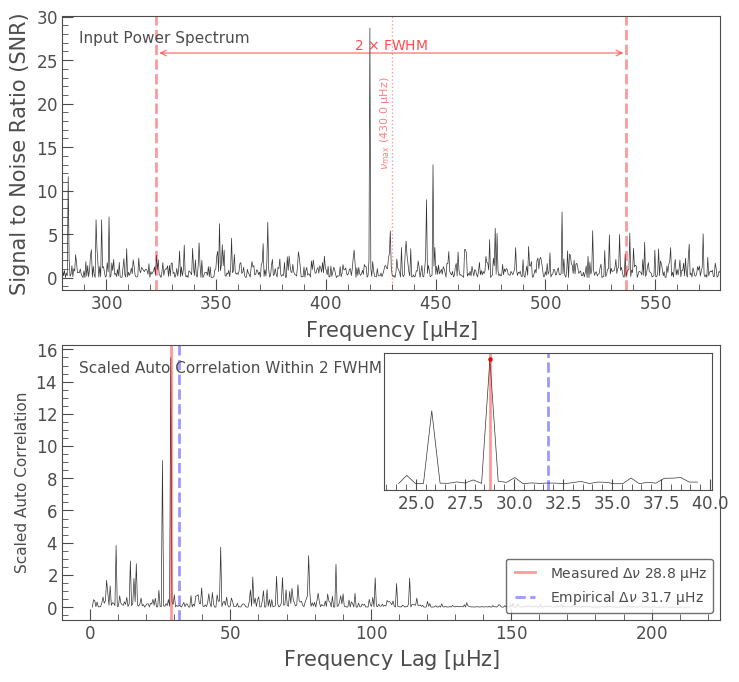

In [12]:
seis.estimate_deltanu()
seis.diagnose_deltanu()

Looking at this diagnostic plot the low frequency resolution of the TESS data really becomes clear. But! We've found a peak close to the empirical value for $\Delta\nu$, indicating that there is a repeated structure with a spacing close to the $\Delta\nu$ we would expect for this star.

This was hard (for me impossible) to see in the regular spectrum, but it's showing up clearly here in the ACF. Let's calculate the stellar parameters, and then compare it to those reported in Huber et al. 2019.

In [13]:
teff = 5080
mass = seis.estimate_mass(teff)

In [14]:
radius = seis.estimate_radius(teff)

In [15]:
logg = seis.estimate_logg(teff)

In [17]:
print('True numax: {} +- {} vs {:.2f} microHz'.format(430, 18, seis.numax.value))
print('True deltanu: {} +- {} vs {:.2f} microHz'.format(28.94, 0.15, seis.deltanu.value))
print('True Radius: {} +- {} vs {:.2f} Rsol'.format(2.943, 0.064, radius.value))
print('True Mass: {} +- {} vs {:.2f} Msol'.format(1.212, 0.074, mass.value))
print('True Logg: {} +- {} vs {:.2f} dex'.format(3.584, 0.010, logg.value))

True numax: 430 +- 18 vs 430.00 microHz
True deltanu: 28.94 +- 0.15 vs 28.78 microHz
True Radius: 2.943 +- 0.064 vs 2.88 Rsol
True Mass: 1.212 +- 0.074 vs 1.08 Msol
True Logg: 3.584 +- 0.01 vs 3.55 dex


Awesome! We've recovered the $\nu_{\rm max}$ and $\Delta\nu$ reported in Huber et al. 2019 almost exactly. The large radius and small surface gravity, but near-solar mass, is an indicator that this star has started to evolve off the main sequence and into the subgiant branch!

This evolution also throws off our estimates a bit though. Despite having asteroseismic parameters close to those in Huber et al. 2019, our stellar parameters are slightly off. This is because our scaling relation method does not account for the star evolving off the main sequence. Furthermore their stellar parameter estimates are based on comparison of *individual frequencies* to stellar models, instead of global asteroseismic parameters like we do. While these parameters are good for an initial look into a star, if you want to *really* characterise a star in depth, using models and individual frequencies is best!

Finally, let's have a look at the echelle diagram.

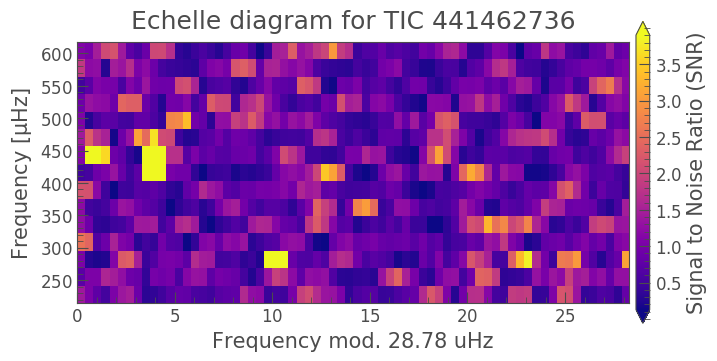

In [18]:
seis.plot_echelle(smooth_filter_width=1, cmap='plasma')

It looks like we can vaguely see the l=0,2 pair. Echelle diagrams aren't always great for analysing stars with poor frequency resolution, like this one. C'est la vie!

In [19]:
seis

Seismology(ID: 441462736) - computed values:
 * numax: 430.00 uHz (method: ACF2D)
 * deltanu: 28.78 uHz (method: ACF2D)
 * mass: 1.08 solMass (method: Uncorrected Scaling Relations)
 * radius: 2.88 solRad (method: Uncorrected Scaling Relations)
 * logg: 3.55 dex (method: Uncorrected Scaling Relations)

In [21]:
lc

TessLightCurve(TICID: 441462736)